<b>Scroll down to the bottom of the page to see the actual graph</b>

In [ ]:
install.packages("reshape2")
install.packages("plotly")

In [13]:
library(dplyr)
library(reshape2)
library(tidyr)
library(ggplot2)
library(tibble)
library(plotly) 

In [14]:
url = "https://raw.githubusercontent.com/asingh2066/Visualization/main/nba_shot_types.csv"
c <- read.csv(url)
head(c)

,YEAR,PLAYER,TEAM,AGE,GP,W,L,MIN,PCT_FGA_2PT,PCT_FGA_3PT,⋯,PCT_PTS_FSTBRK,PCT_PTS_FT,PCT_PTS_OFF_TOS,PCT_PTS_INTHEPT,PCT_2PTGFM_ASSTD,PCT_2PTGFM_UNASSTD,PCT_3PTGFM_ASSTD,PCT_3PTGFM_UNASSTD,PCT_FGM_ASSTD,PCT_FGM_UNASSTD
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2018-2019,Aaron Gordon,ORL,23,78,40,38,33.8,66.8,33.2,⋯,12.0,14.8,13.7,46.7,50.4,49.6,84.3,15.7,59.1,40.9
2,2018-2019,Aaron Holiday,IND,22,50,31,19,12.9,51.5,48.5,⋯,15.0,13.9,16.3,29.3,38.7,61.3,79.1,20.9,55.2,44.8
3,2018-2019,Abdel Nader,OKC,25,61,38,23,11.4,53.5,46.5,⋯,18.7,11.2,20.3,47.3,49.2,50.8,96.9,3.1,65.9,34.1
4,2018-2019,Al Horford,BOS,33,68,41,27,29.0,71.9,28.1,⋯,5.0,8.4,11.5,47.8,75.2,24.8,100.0,0.0,79.8,20.2
5,2018-2019,Al-Farouq Aminu,POR,28,81,52,29,28.3,52.8,47.2,⋯,13.6,19.7,15.9,40.5,51.6,48.4,100.0,0.0,69.6,30.4
6,2018-2019,Alan Williams,BKN,26,5,1,4,5.1,92.3,7.7,⋯,0.0,11.1,0.0,77.8,75.0,25.0,0.0,0.0,75.0,25.0


<b>The histogram help determine which seasons data is not usable, by looking at the density plots of the same statistics grouped by seasons. </b>

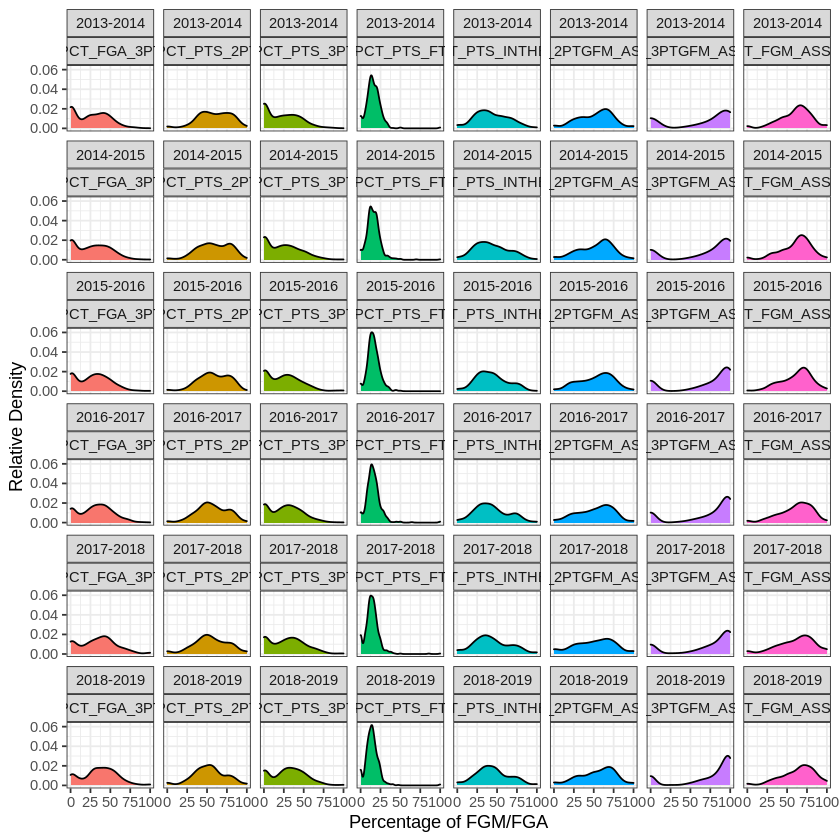

In [15]:
c %>% select(1:3, 10:11, 13, 15, 17:18, 20, 22) %>%
  melt(c('YEAR', 'PLAYER', 'TEAM')) %>%
  ggplot(aes(x = value)) +
  geom_density(aes(fill = variable)) +
  facet_wrap(YEAR ~ variable, nrow = length(unique(c$YEAR))) +
  labs(x = 'Percentage of FGM/FGA', y = 'Relative Density') +
  theme_bw() +
  guides(fill = FALSE)

<b>Principal Component Analysis and PCA Analysis of NBA Shot Type Dataset</b>


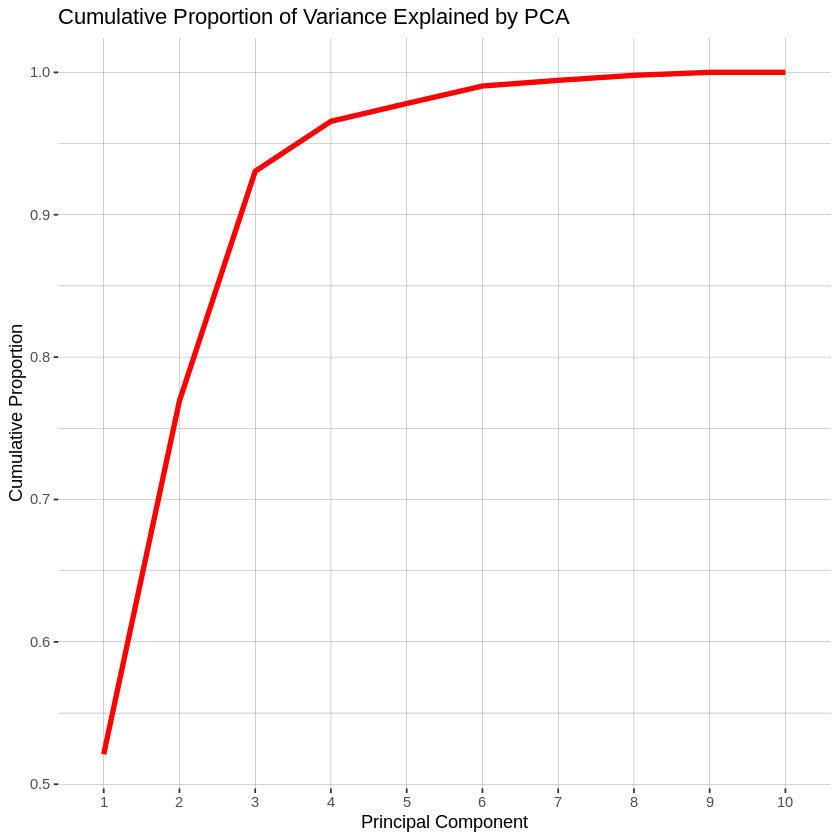

In [16]:
set.seed(07072019)
c.train = c %>%
  filter(YEAR %in% c('2016-2017', '2017-2018', '2018-2019'), GP >= 20) %>%
  select(contains('PCT')) %>%
  select(2, 4:10, 12, 14)
pca = summary(prcomp(c.train))
t(pca$importance) %>%
  as.data.frame() %>%
  tibble::rownames_to_column() %>%
  ggplot() +
  geom_line(aes(x = factor(rowname, levels = paste('PC', seq(1, 10, 1), sep = ''), labels = seq(1, 10, 1)), y = `Cumulative Proportion`), group = 1, color = 'red', size = 1.5) +
  labs(title = 'Cumulative Proportion of Variance Explained by PCA',
       x = 'Principal Component') +
  theme(panel.background = element_rect(fill = 'white'),
       panel.grid.major = element_line(color = 'grey50', size = .1),
       panel.grid.minor = element_line(color = 'grey50', size = .1))


In [17]:
pca

Importance of components:
                          PC1     PC2     PC3     PC4    PC5     PC6    PC7
Standard deviation     39.748 27.4365 22.1141 10.3175 6.1567 6.09903 3.4807
Proportion of Variance  0.521  0.2482  0.1613  0.0351 0.0125 0.01227 0.0040
Cumulative Proportion   0.521  0.7693  0.9305  0.9656 0.9781 0.99041 0.9944
                           PC8     PC9    PC10
Standard deviation     3.27842 2.49386 0.02857
Proportion of Variance 0.00354 0.00205 0.00000
Cumulative Proportion  0.99795 1.00000 1.00000

The first two components contribute 76.9% of the data, meaning we can create a two dimensional PCA componenet visual to showcase the data since the variance is above 70%. We will use the first two components to transform the 10 dimensional dataset into a 2 dimensional dataset. 


<b> K-Means Clustering Analysis </b>

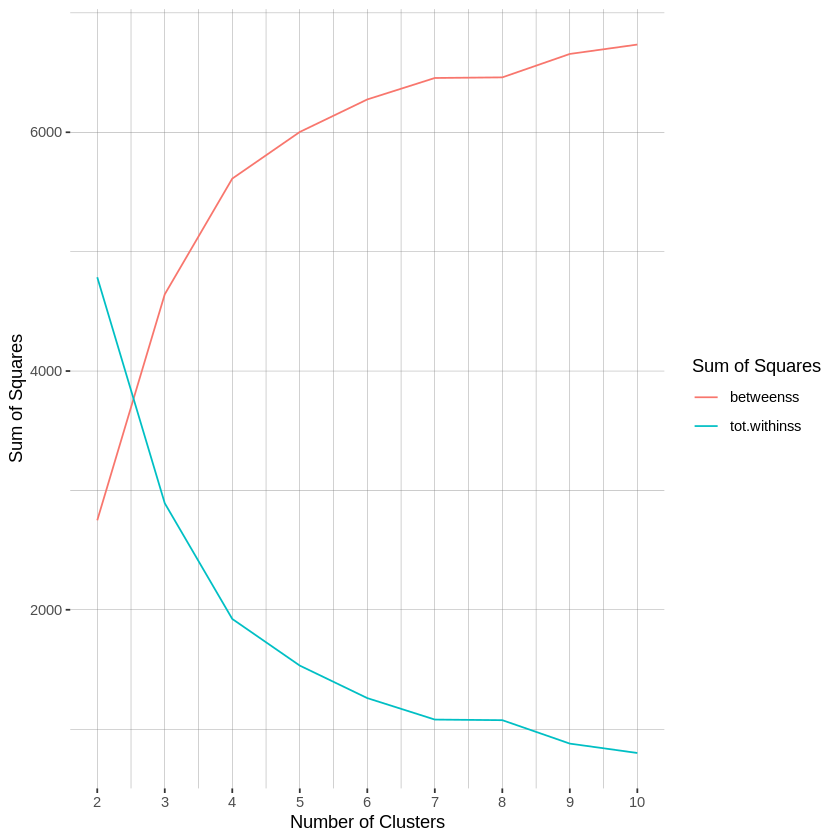

In [18]:
three_directions <- prcomp(c.train)$rotation[,1:3]
sd_vector <- sapply(c.train, sd)
scaled_best_directions <- three_directions / sd_vector
PCA_dimension_pts <- as.matrix(c.train) %*% scaled_best_directions

kmeans_plot = function(matrix, max_clusters){
  betweenss = numeric(max_clusters - 1)
  tot.withinss = numeric(max_clusters - 1)
  for (i in 2:max_clusters){
    clustering = kmeans(matrix, i)
    betweenss[i-1] = clustering$betweenss
    tot.withinss[i-1] = clustering$tot.withinss
  }
  
  plot = cbind(betweenss, tot.withinss) %>%
    reshape2::melt(.) %>%
    mutate(Var1 = c(seq(2, max_clusters, 1), seq(2, max_clusters, 1))) %>%
    rename('Sum of Squares' = Var2) %>%
    ggplot() +
    geom_line(aes(x = Var1, y = value, color = `Sum of Squares`)) +
    labs(x = 'Number of Clusters', y = 'Sum of Squares') +
    scale_x_continuous(labels = seq(2, max_clusters, 1), breaks = seq(2, max_clusters, 1)) +
    theme(panel.background = element_rect(fill = 'white'),
          panel.grid.major = element_line(color = 'grey50', size = .1),
          panel.grid.minor = element_line(color = 'grey50', size = .1),
          legend.key = element_rect(fill = 'white'))
  return(plot)
}

kmeans_plot(PCA_dimension_pts, 10)

The blue line shown here shows the sum of the groups within the cluster variances for each number of clusters given, while the red line gives us the between-cluster variance. 


<b>Two-Component PCA Visualization</b>

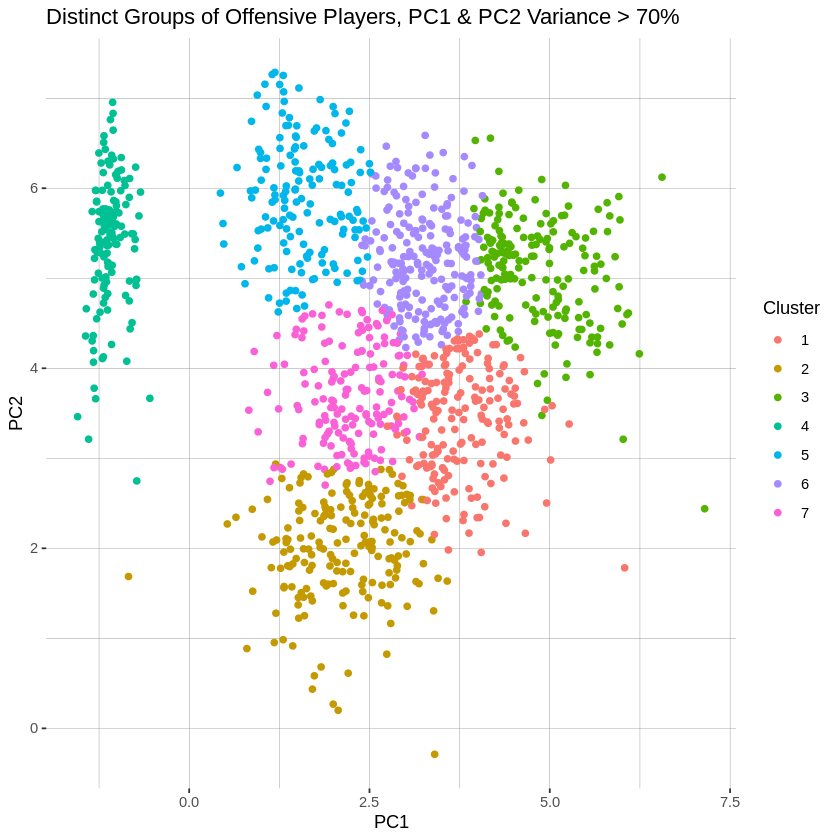

In [19]:
PCA_kmeans = kmeans(PCA_dimension_pts, 7)
PCA_kmeans_df <- cbind(c %>% filter(YEAR %in% c('2016-2017', '2017-2018', '2018-2019'), GP >= 20), PCA_dimension_pts, cluster = PCA_kmeans$cluster)
ggplot(PCA_kmeans_df) +
  geom_jitter(aes(x = PC1, y = PC2, color = factor(cluster, levels = seq(1, 7, 1)))) +
  guides(color = guide_legend('Cluster')) +
  labs(title = 'Distinct Groups of Offensive Players, PC1 & PC2 Variance > 70%') +
  theme(panel.background = element_rect(fill = 'white'),
       panel.grid.major = element_line(color = 'grey50', size = .1),
       panel.grid.minor = element_line(color = 'grey50', size = .1),
       legend.key = element_rect(fill = 'white'))

You can conclude from this graph that there are 7 different range groups for offensive performance in the NBA. You can further view the players that fall within these ranges from the tables below. The graph above is showcasing seven different clusters, each representing a different range of mean statistics for NBA players. Based on these mean statistics, each NBA is given a distinct cluster, with very few outliers. The seven clusters are just the different groups of performance, each cluster is based on mean performance, so out of all the NBA players in the seasons from 2016-2019, you can categorize their offensive performance into 7 groups. With each NBA-player averaging in their own group. You can view the table below to see the different mean values for each cluster group, and the table below that one too see which player received which group based on performance.

In [20]:
PCA_cluster_means <- PCA_kmeans_df %>% 
  select_if(grepl('PCT', colnames(PCA_kmeans_df))) %>%
  cbind(cluster = PCA_kmeans_df$cluster, .) %>%
  group_by(cluster) %>%
  summarise_all(mean)
PCA_cluster_means

cluster,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_MR,PCT_PTS_3PT,PCT_PTS_FSTBRK,PCT_PTS_FT,PCT_PTS_OFF_TOS,PCT_PTS_INTHEPT,PCT_2PTGFM_ASSTD,PCT_2PTGFM_UNASSTD,PCT_3PTGFM_ASSTD,PCT_3PTGFM_UNASSTD,PCT_FGM_ASSTD,PCT_FGM_UNASSTD
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,50.67188,49.3281250,40.23385,12.398958,46.34843750,13.05104,13.41302,15.41510,27.83438,41.68802,58.31302,83.84948,16.151563,60.25885,39.74115
2,66.40000,33.6000000,53.42421,16.377895,29.07157895,12.82895,17.50368,15.31684,37.04684,21.67263,78.32842,62.23421,37.240526,32.50053,67.50105
3,37.86649,62.1335106,31.54043,8.346277,58.12606383,12.46596,10.33617,14.96649,23.19309,69.93723,29.53085,95.69894,4.301064,84.56064,15.43989
4,99.24892,0.7510791,82.08489,6.619424,0.07410072,7.71295,17.84029,14.06403,75.46187,68.65396,31.34604,0.00000,5.035971,68.62446,31.37554
5,88.50962,11.4910256,75.52692,9.246154,7.68461538,10.15256,16.79423,15.49679,66.27885,67.65897,32.34167,97.76154,2.239744,69.63654,30.36474
6,61.59045,38.4104545,53.00955,9.995909,32.92863636,13.19818,14.06182,16.61273,43.01727,65.45636,34.54364,95.76364,4.237273,74.42091,25.58045
7,73.80061,26.2000000,61.10727,13.392121,21.76545455,13.17515,17.12485,15.98182,47.72121,40.99818,59.00242,86.40000,13.600606,49.60364,50.39697


The means of the original variables we inputted for each cluster of players we created. 

In [21]:
PCA_kmeans_df

YEAR,PLAYER,TEAM,AGE,GP,W,L,MIN,PCT_FGA_2PT,PCT_FGA_3PT,⋯,PCT_2PTGFM_ASSTD,PCT_2PTGFM_UNASSTD,PCT_3PTGFM_ASSTD,PCT_3PTGFM_UNASSTD,PCT_FGM_ASSTD,PCT_FGM_UNASSTD,PC1,PC2,PC3,cluster
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2018-2019,Aaron Gordon,ORL,23,78,40,38,33.8,66.8,33.2,⋯,50.4,49.6,84.3,15.7,59.1,40.9,2.6014873,4.244273,-0.12955972,7
2018-2019,Aaron Holiday,IND,22,50,31,19,12.9,51.5,48.5,⋯,38.7,61.3,79.1,20.9,55.2,44.8,3.5213206,3.149155,0.49047780,1
2018-2019,Abdel Nader,OKC,25,61,38,23,11.4,53.5,46.5,⋯,49.2,50.8,96.9,3.1,65.9,34.1,3.5082562,4.408746,0.14495929,6
2018-2019,Al Horford,BOS,33,68,41,27,29.0,71.9,28.1,⋯,75.2,24.8,100.0,0.0,79.8,20.2,2.8744270,5.915739,-0.04753702,6
2018-2019,Al-Farouq Aminu,POR,28,81,52,29,28.3,52.8,47.2,⋯,51.6,48.4,100.0,0.0,69.6,30.4,3.5961787,4.538764,0.19898955,6
2018-2019,Alec Burks,SAC,27,64,19,45,21.5,64.6,35.4,⋯,42.0,58.0,77.0,23.0,53.1,46.9,2.5980909,3.569106,0.02902277,7
2018-2019,Alex Abrines,OKC,25,31,21,10,19.0,19.1,80.9,⋯,80.0,20.0,95.1,4.9,91.1,8.9,5.9053844,5.238779,2.76132444,3
2018-2019,Alex Caruso,LAL,25,25,8,17,21.2,71.1,28.9,⋯,41.5,58.5,66.7,33.3,49.4,50.6,2.1688059,3.433556,-0.02299121,7
2018-2019,Alex Len,ATL,25,77,28,49,20.1,68.5,31.5,⋯,72.0,28.0,98.6,1.4,78.1,21.9,2.7047714,5.964204,0.01118030,6


The line above can be run to see the PC1, PC2, and Cluster value assigned to each NBA player based on the statiscial mean of their performance throughout the seasons, offensively.

---

